In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import 
plt.style.use("seaborn")

/var/folders/kq/ps63fdtn2yvcch21qn3fl_t80000gn/T/ipykernel_8597/1123596123.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [4]:
data = pd.read_csv("bitcoin.csv", parse_dates = ["Date"], index_col = "Date")
data

,Open,High,Low,Close,Volume
Date,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2021-10-07 05:00:00,55073.20,55073.21,54545.07,54735.76,2251.122020
2021-10-07 06:00:00,54735.77,54968.06,54375.83,54534.16,1783.004260
2021-10-07 07:00:00,54534.16,54793.26,54235.33,54755.92,4163.431360


In [7]:
data.info()
data["returns"] = np.log(data.Close/data.Close.shift(1))
data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36168 entries, 2017-08-17 04:00:00 to 2021-10-07 09:00:00
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open     36168 non-null  float64
 1   High     36168 non-null  float64
 2   Low      36168 non-null  float64
 3   Close    36168 non-null  float64
 4   Volume   36168 non-null  float64
 5   returns  36167 non-null  float64
dtypes: float64(6)
memory usage: 2.9 MB


,Open,High,Low,Close,Volume,returns
Date,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,NaN
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,0.001505
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,0.002090
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,0.005912
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,0.002457
...,...,...,...,...,...,...
2021-10-07 05:00:00,55073.20,55073.21,54545.07,54735.76,2251.122020,-0.006146
2021-10-07 06:00:00,54735.77,54968.06,54375.83,54534.16,1783.004260,-0.003690
2021-10-07 07:00:00,54534.16,54793.26,54235.33,54755.92,4163.431360,0.004058


In [14]:
from pyrsistent import thaw


def backtest(data, parameter, tc):
    # prepare features
    data = data[["Close", "Volume", "returns"]].copy()
    data["vol_ch"] = np.log(data.Volume.div(data.Volume.shift(1)))
    data.loc[data.vol_ch > 3, "vol_ch"] = np.nan
    data.loc[data.vol_ch < -3 , "vol_ch"] = np.nan

    # define trading postions
    return_th = np.percentile(data.returns.dropna(), parameter[0])
    cond1 = data.returns >= return_th
    volume_th = np.percentile(data.vol_ch.dropna(), [parameter[1], parameter[2]])
    cond2 = data.vol_ch.between(volume_th[0], volume_th[1])

    data["position"] = 1
    data.loc[cond1 & cond2, "position"] = 0

    # backtest
    data["strategy"] = data.position.shift(1)* data["returns"]
    data["trades"] = data.position.diff().fillna(0).abs()
    data.strategy = data.strategy + data.trades * tc
    data["creturns"] = data["returns"].cumsum().apply(np.exp)
    data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)

    return data.cstrategy[-1]


In [15]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
backtest(data = data, parameter = (90, 5, 20), tc = -0.01)

0.02672089501616669

In [42]:
return_range = range(85, 99, 1) # potential values for return_th
vol_low_range = range(2, 50, 1) # potential values for vol_low
vol_high_range = range(50, 100,1) # potential vaues for vol_high

In [43]:
list(return_range)

[85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]

In [44]:
# run backtest on all ranges and find the combination with the best result

from itertools import product

In [45]:
combinations = list(product(return_range, vol_low_range, vol_high_range))
combinations

[(85, 2, 50),
 (85, 2, 51),
 (85, 2, 52),
 (85, 2, 53),
 (85, 2, 54),
 (85, 2, 55),
 (85, 2, 56),
 (85, 2, 57),
 (85, 2, 58),
 (85, 2, 59),
 (85, 2, 60),
 (85, 2, 61),
 (85, 2, 62),
 (85, 2, 63),
 (85, 2, 64),
 (85, 2, 65),
 (85, 2, 66),
 (85, 2, 67),
 (85, 2, 68),
 (85, 2, 69),
 (85, 2, 70),
 (85, 2, 71),
 (85, 2, 72),
 (85, 2, 73),
 (85, 2, 74),
 (85, 2, 75),
 (85, 2, 76),
 (85, 2, 77),
 (85, 2, 78),
 (85, 2, 79),
 (85, 2, 80),
 (85, 2, 81),
 (85, 2, 82),
 (85, 2, 83),
 (85, 2, 84),
 (85, 2, 85),
 (85, 2, 86),
 (85, 2, 87),
 (85, 2, 88),
 (85, 2, 89),
 (85, 2, 90),
 (85, 2, 91),
 (85, 2, 92),
 (85, 2, 93),
 (85, 2, 94),
 (85, 2, 95),
 (85, 2, 96),
 (85, 2, 97),
 (85, 2, 98),
 (85, 2, 99),
 (85, 3, 50),
 (85, 3, 51),
 (85, 3, 52),
 (85, 3, 53),
 (85, 3, 54),
 (85, 3, 55),
 (85, 3, 56),
 (85, 3, 57),
 (85, 3, 58),
 (85, 3, 59),
 (85, 3, 60),
 (85, 3, 61),
 (85, 3, 62),
 (85, 3, 63),
 (85, 3, 64),
 (85, 3, 65),
 (85, 3, 66),
 (85, 3, 67),
 (85, 3, 68),
 (85, 3, 69),
 (85, 3, 70),
 (85, 

In [46]:
results =  []

for comb in combinations:
    results.append(backtest(data = data, parameter  = comb, tc = -0.01))

many_results = pd.DataFrame(data = combinations, columns= ["returns", "vol_low", "vol_high"])
many_results["performance"] = results

In [47]:
many_results

,returns,vol_low,vol_high,performance
0,85,2,50,8.749734e-15
1,85,2,51,3.302679e-15
2,85,2,52,1.347018e-15
3,85,2,53,7.820003e-16
4,85,2,54,3.539131e-16
...,...,...,...,...
33595,98,49,95,1.706265e-02
33596,98,49,96,1.250437e-02
33597,98,49,97,7.498055e-03
33598,98,49,98,4.391183e-03


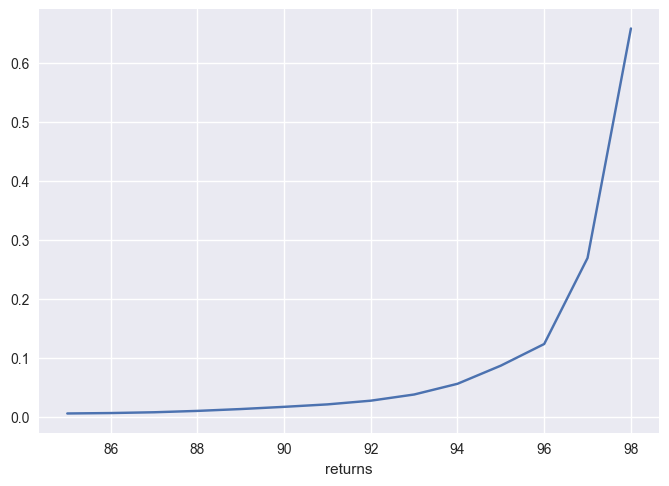

In [48]:
many_results.groupby("returns").performance.mean().plot()
plt.show()

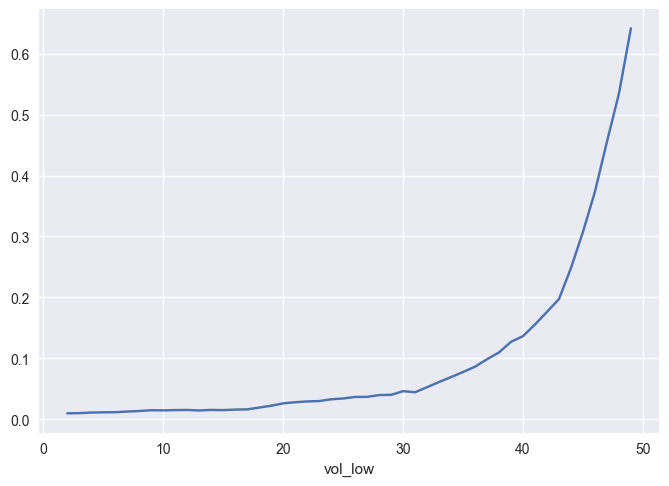

In [49]:
many_results.groupby("vol_low").performance.mean().plot()
plt.show()

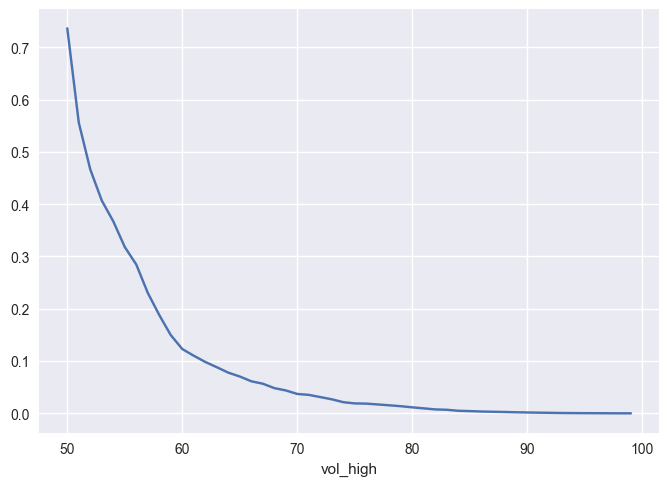

In [50]:
many_results.groupby("vol_high").performance.mean().plot()
plt.show()